# Model 1


Training Model 1 (Static) with data up to 2015-12-31...
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9487 - auc_pr: 0.0303 - loss: 0.2249 - precision: 0.0404 - recall: 0.0567 - val_accuracy: 0.9783 - val_auc_pr: 0.3976 - val_loss: 0.0658 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9786 - auc_pr: 0.2817 - loss: 0.0753 - precision: 0.6680 - recall: 0.0202 - val_accuracy: 0.9791 - val_auc_pr: 0.5324 - val_loss: 0.0508 - val_precision: 0.8571 - val_recall: 0.0443
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9799 - auc_pr: 0.4485 - loss: 0.0578 - precision: 0.6772 - recall: 0.1032 - val_accuracy: 0.9829 - val_auc_pr: 0.6117 - val_loss: 0.0442 - val_precision: 0.7395 - val_recall: 0.3247
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9821 - auc_pr: 0.5659 - loss: 0.0491 - precision: 0.7262 - recall: 0.2902 - val_accuracy: 0.9850 - val_auc_pr: 0.6723 - val_loss: 0.0

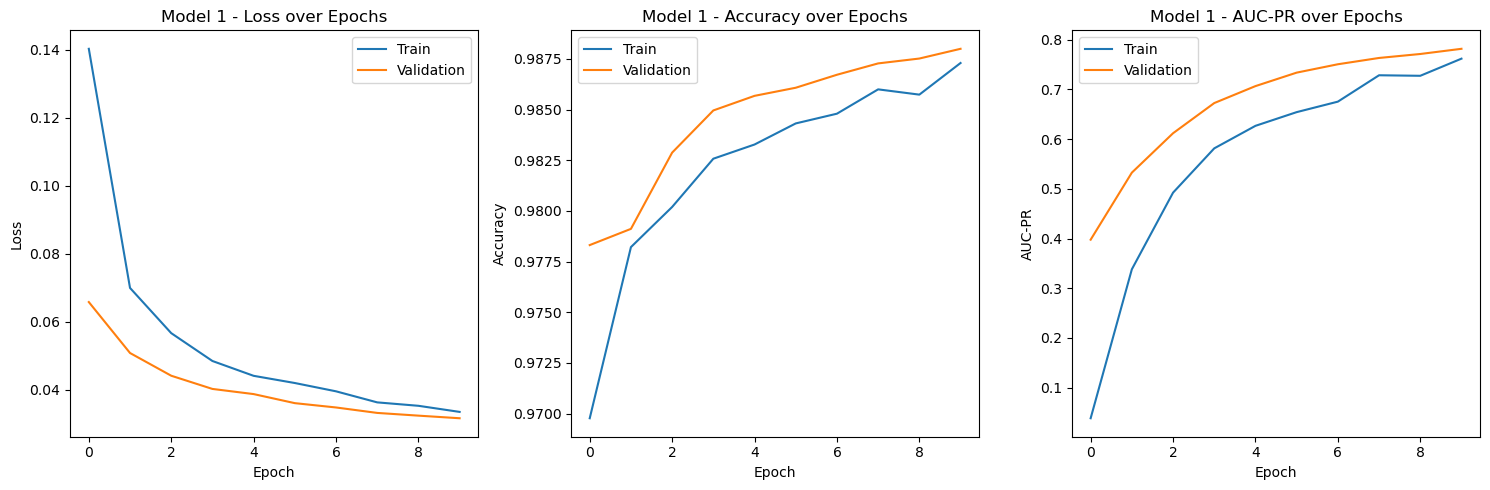

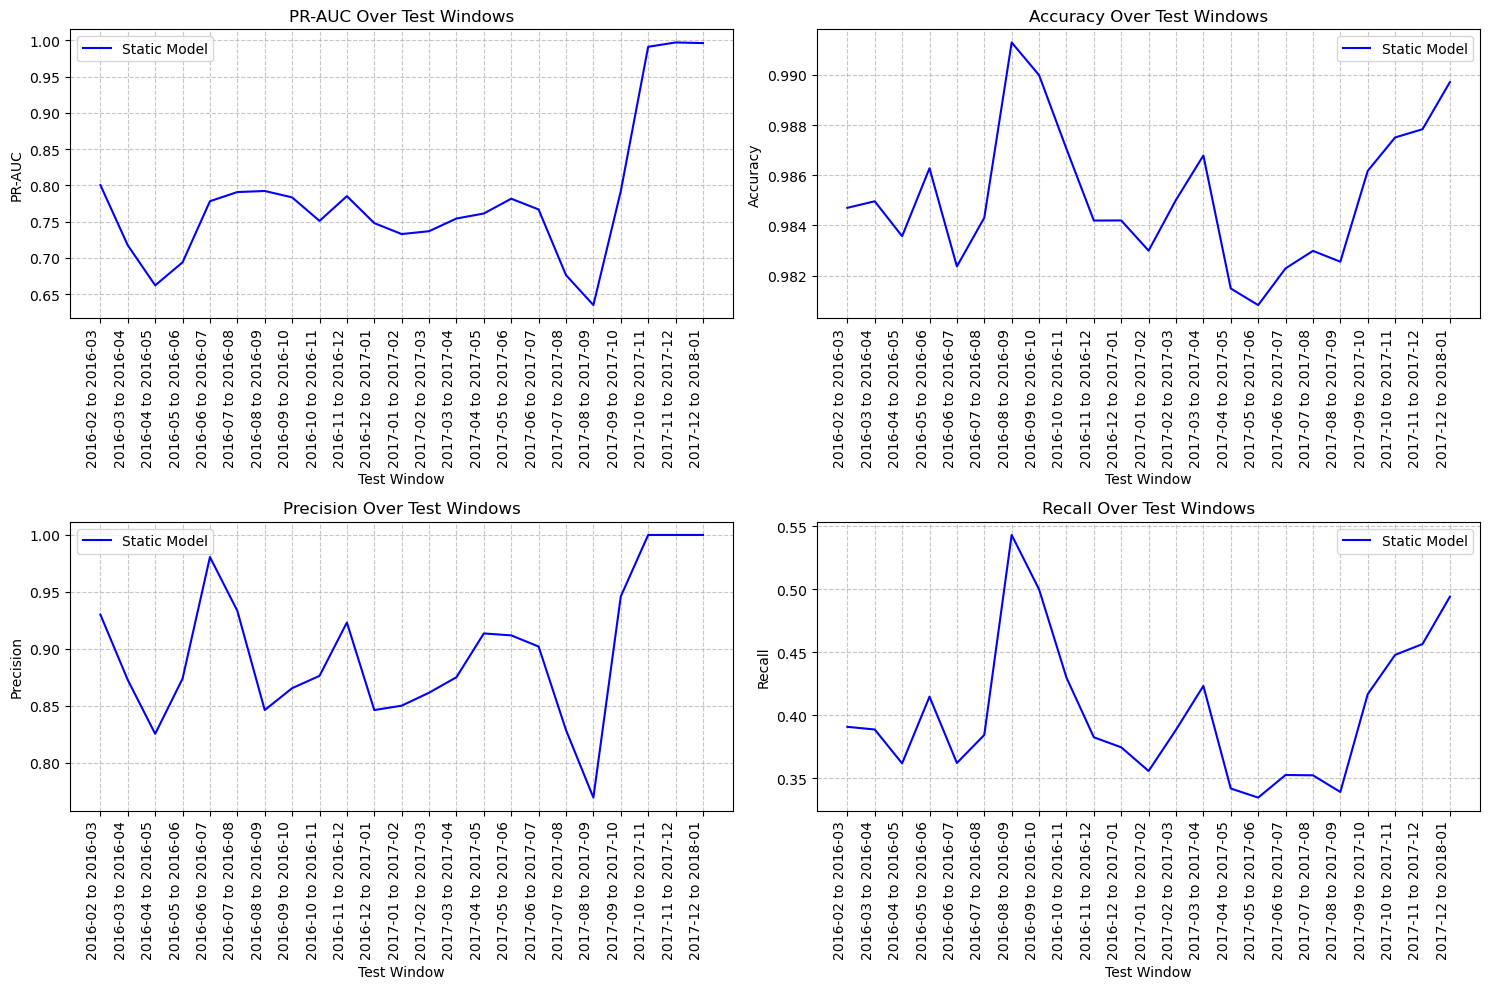

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import calendar

# --------------  Data Loading & Time periods Setup  --------------
df = pd.read_pickle("C:/Users/hridi/Downloads/WF_DCPT project/Jan 17th presentation_ 4 Seperate models/model_ready_data.pkl")

# Define time periods
initial_start = pd.Timestamp('2015-01-01')
initial_end = pd.Timestamp('2015-12-31')
training_end = pd.Timestamp('2017-11-30')
eval_end = pd.Timestamp('2018-01-31')

# -------------- Model 1: Data Preparation --------------
# Get initial training data (2015)
initial_data = df[df['order_date'] <= initial_end] #1 year
# Prepare the dataset
X_initial = initial_data.drop(columns=['fraud', 'order_date'])
y_initial = initial_data['fraud']

# Split and scale initial data
X_train, X_val, y_train, y_val = train_test_split(
    X_initial, y_initial, 
    test_size=0.2, 
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# -------------- Model 1: Architecture --------------
def create_model(learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Input(shape=(39,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
    )
    return model

# -------------- Model 1: Training --------------
print(f"\nTraining Model 1 (Static) with data up to {initial_end.strftime('%Y-%m-%d')}...")

model1 = create_model()
history1 = model1.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=512,
    verbose=1
)

# Store training metrics
model1_train_results = pd.DataFrame({
    'epoch': range(1, len(history1.history['loss']) + 1),
    'loss': history1.history['loss'],
    'val_loss': history1.history['val_loss'],
    'accuracy': history1.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'],
    'auc_pr': history1.history['auc_pr'],
    'val_auc_pr': history1.history['val_auc_pr']
})

# -------------- Model 1: Testing on Rolling Windows --------------
# Initialize results storage
model1_results = []

# Test window parameters
last_valid_start = pd.Timestamp('2017-12-01')
current_date = pd.Timestamp('2016-02-01')

# Evaluate on rolling windows
while current_date <= last_valid_start:
    # Define test window
    test_start = current_date
    test_end_month = current_date.month + 1
    test_end_year = current_date.year
    if test_end_month > 12:
        test_end_month -= 12
        test_end_year += 1
    
    last_day = calendar.monthrange(test_end_year, test_end_month)[1]
    test_end = pd.Timestamp(f"{test_end_year}-{test_end_month:02d}-{last_day:02d}")
    
    # Get test data
    test_mask = (df['order_date'] > test_start) & (df['order_date'] <= test_end)
    test_data = df[test_mask]
    
    if len(test_data) > 0:
        # Prepare test data
        X_test = test_data.drop(columns=['fraud', 'order_date'])
        y_test = test_data['fraud']
        X_test_scaled = scaler.transform(X_test)
        
        # Get predictions
        y_pred_proba = model1.predict(X_test_scaled, verbose=0)
        threshold = np.quantile(y_pred_proba, 0.99)  # Top 1%
        y_pred = (y_pred_proba >= threshold).astype(int)
        print(f"Threshold value for this window: {threshold}")
        
        # Calculate metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precisions, recalls, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recalls, precisions)
        
        # Store results
        model1_results.append({
            'date': current_date,
            'model_name': 'Static',  # Changed from 'model' to 'model_name' for consistency
            'window': f"{test_start.strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            'PR-AUC': pr_auc,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision,
            'Recall': recall
        })
    
    current_date += pd.DateOffset(months=1)

# Convert results to DataFrame
model1_test_results = pd.DataFrame(model1_results)

# Store final results for comparison
model1_final_results = {
    'model_name': 'Static',
    'train_metrics': model1_train_results,
    'test_metrics': model1_test_results
}

# Save results for later comparison
np.save('model1_results.npy', model1_final_results, allow_pickle=True)

# Print summary metrics
print("\nModel 1 (Static) Test Metrics:")
print(model1_test_results[['window', 'PR-AUC', 'Accuracy', 'Precision', 'Recall']])
print("\nAverage Test Metrics:")
print(model1_test_results[['PR-AUC', 'Accuracy', 'Precision', 'Recall']].mean())



# -------------- Model 1: Plot Training Metrics --------------
plt.figure(figsize=(15, 5))
metrics_to_plot = {
    'Loss': ['loss', 'val_loss'],
    'Accuracy': ['accuracy', 'val_accuracy'],
    'AUC-PR': ['auc_pr', 'val_auc_pr']
}

for i, (metric_name, metric_keys) in enumerate(metrics_to_plot.items()):
    plt.subplot(1, 3, i + 1)
    plt.plot(history1.history[metric_keys[0]], label='Train')
    plt.plot(history1.history[metric_keys[1]], label='Validation')
    plt.title(f'Model 1 - {metric_name} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
plt.tight_layout()
plt.show()


# -------------- Model 1: Plot Test Metrics --------------
plt.figure(figsize=(15, 10))
metrics = ['PR-AUC', 'Accuracy', 'Precision', 'Recall']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.plot(range(len(model1_test_results)), model1_test_results[metric], label='Static Model', color='blue')
    plt.title(f'{metric} Over Test Windows')
    plt.xlabel('Test Window')
    plt.ylabel(metric)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Use window labels for x-axis
    plt.xticks(range(len(model1_test_results)), 
               model1_test_results['window'], 
               rotation=90,
               ha='right')

plt.tight_layout()
plt.show()

# Model 3


Starting Model 3 (Dynamic Full_train - Training)...

Retraining Model 3 for data up to 2016-01-31...
Training data size: 67803
Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7864 - auc_pr: 0.0225 - loss: 0.4297 - precision: 0.0212 - recall: 0.1859 - val_accuracy: 0.9799 - val_auc_pr: 0.2643 - val_loss: 0.0710 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9776 - auc_pr: 0.1105 - loss: 0.0893 - precision: 0.1348 - recall: 0.0047 - val_accuracy: 0.9801 - val_auc_pr: 0.5760 - val_loss: 0.0469 - val_precision: 1.0000 - val_recall: 0.0110
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9780 - auc_pr: 0.3985 - loss: 0.0651 - precision: 0.7188 - recall: 0.0484 - val_accuracy: 0.9816 - val_auc_pr: 0.6600 - val_loss: 0.0395 - val_precision: 0.9286 - val_recall: 0.0952
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9807 - auc_pr: 0.5554 - loss: 0.0520 - precision: 0.79

Epoch 9/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9875 - auc_pr: 0.7645 - loss: 0.0331 - precision: 0.7692 - recall: 0.6237 - val_accuracy: 0.9889 - val_auc_pr: 0.8200 - val_loss: 0.0292 - val_precision: 0.7500 - val_recall: 0.7207
Epoch 10/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - auc_pr: 0.7859 - loss: 0.0326 - precision: 0.7699 - recall: 0.6649 - val_accuracy: 0.9898 - val_auc_pr: 0.8200 - val_loss: 0.0289 - val_precision: 0.7825 - val_recall: 0.7237

Retraining Model 3 for data up to 2016-04-30...
Training data size: 83035
Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9576 - auc_pr: 0.0241 - loss: 0.2148 - precision: 0.0244 - recall: 0.0191 - val_accuracy: 0.9802 - val_auc_pr: 0.5186 - val_loss: 0.0558 - val_precision: 0.9200 - val_recall: 0.0657
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9791 - auc_pr: 0.3790 - loss: 0.0704 - precision: 0.8113 - recall: 0.1094 - val_accuracy: 0.9840 - val_auc_pr: 0.6

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9866 - auc_pr: 0.7226 - loss: 0.0365 - precision: 0.7654 - recall: 0.5691 - val_accuracy: 0.9892 - val_auc_pr: 0.8015 - val_loss: 0.0291 - val_precision: 0.7853 - val_recall: 0.6881
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9887 - auc_pr: 0.7723 - loss: 0.0320 - precision: 0.8078 - recall: 0.6444 - val_accuracy: 0.9898 - val_auc_pr: 0.8143 - val_loss: 0.0280 - val_precision: 0.8057 - val_recall: 0.6980
Epoch 9/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9875 - auc_pr: 0.7779 - loss: 0.0331 - precision: 0.7871 - recall: 0.6124 - val_accuracy: 0.9895 - val_auc_pr: 0.8132 - val_loss: 0.0278 - val_precision: 0.8071 - val_recall: 0.6733
Epoch 10/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9878 - auc_pr: 0.7827 - loss: 0.0308 - precision: 0.7817 - recall: 0.6229 - val_accuracy: 0.9898 - val_auc_pr: 0.8249 - val_loss: 0.0267 - val_precision: 0.7934 - val_recall: 0.7129

Retraining Model 

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9852 - auc_pr: 0.7091 - loss: 0.0401 - precision: 0.7564 - recall: 0.5426 - val_accuracy: 0.9891 - val_auc_pr: 0.7756 - val_loss: 0.0296 - val_precision: 0.7826 - val_recall: 0.6472
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9853 - auc_pr: 0.7114 - loss: 0.0375 - precision: 0.7139 - recall: 0.5730 - val_accuracy: 0.9891 - val_auc_pr: 0.7837 - val_loss: 0.0286 - val_precision: 0.7899 - val_recall: 0.6337
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9872 - auc_pr: 0.7588 - loss: 0.0356 - precision: 0.7945 - recall: 0.6058 - val_accuracy: 0.9894 - val_auc_pr: 0.7911 - val_loss: 0.0277 - val_precision: 0.7902 - val_recall: 0.6517
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9879 - auc_pr: 0.7633 - loss: 0.0331 - precision: 0.7924 - recall: 0.6167 - val_accuracy: 0.9891 - val_auc_pr: 0.8012 - val_loss: 0.0269 - val_precision: 0.7373 - val_recall: 0.7191
Epoch 9/10
171/171 

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9820 - auc_pr: 0.5634 - loss: 0.0533 - precision: 0.6918 - recall: 0.3998 - val_accuracy: 0.9859 - val_auc_pr: 0.7158 - val_loss: 0.0377 - val_precision: 0.7699 - val_recall: 0.5109
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9836 - auc_pr: 0.6378 - loss: 0.0453 - precision: 0.6926 - recall: 0.4785 - val_accuracy: 0.9867 - val_auc_pr: 0.7499 - val_loss: 0.0347 - val_precision: 0.7698 - val_recall: 0.5655
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9850 - auc_pr: 0.6837 - loss: 0.0403 - precision: 0.7265 - recall: 0.5307 - val_accuracy: 0.9875 - val_auc_pr: 0.7633 - val_loss: 0.0332 - val_precision: 0.7815 - val_recall: 0.5982
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9860 - auc_pr: 0.7211 - loss: 0.0380 - precision: 0.7406 - recall: 0.5884 - val_accuracy: 0.9879 - val_auc_pr: 0.7748 - val_loss: 0.0312 - val_precision: 0.7633 - val_recall: 0.6509
Epoch 7/10
196/196 

220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9258 - auc_pr: 0.0324 - loss: 0.2215 - precision: 0.0258 - recall: 0.0530 - val_accuracy: 0.9809 - val_auc_pr: 0.5736 - val_loss: 0.0509 - val_precision: 0.8345 - val_recall: 0.1844
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9808 - auc_pr: 0.4745 - loss: 0.0576 - precision: 0.7230 - recall: 0.2082 - val_accuracy: 0.9855 - val_auc_pr: 0.7132 - val_loss: 0.0390 - val_precision: 0.8284 - val_recall: 0.4452
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9823 - auc_pr: 0.5910 - loss: 0.0475 - precision: 0.7055 - recall: 0.3736 - val_accuracy: 0.9870 - val_auc_pr: 0.7690 - val_loss: 0.0343 - val_precision: 0.8177 - val_recall: 0.5421
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9840 - auc_pr: 0.6598 - loss: 0.0412 - precision: 0.7063 - recall: 0.4802 - val_accuracy: 0.9876 - val_auc_pr: 0.7904 - val_loss: 0.0317 - val_precision: 0.7850 - val_recall: 0.6153
Epoch 5/10
220/220 

236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9890 - auc_pr: 0.8131 - loss: 0.0289 - precision: 0.8053 - recall: 0.6831 - val_accuracy: 0.9901 - val_auc_pr: 0.8584 - val_loss: 0.0241 - val_precision: 0.8148 - val_recall: 0.7053
Epoch 10/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9895 - auc_pr: 0.8052 - loss: 0.0282 - precision: 0.8045 - recall: 0.6849 - val_accuracy: 0.9904 - val_auc_pr: 0.8667 - val_loss: 0.0233 - val_precision: 0.8112 - val_recall: 0.7282

Retraining Model 3 for data up to 2017-06-30...
Training data size: 155998
Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8859 - auc_pr: 0.0387 - loss: 0.2692 - precision: 0.0337 - recall: 0.1213 - val_accuracy: 0.9814 - val_auc_pr: 0.6006 - val_loss: 0.0496 - val_precision: 0.8876 - val_recall: 0.2113
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9802 - auc_pr: 0.4600 - loss: 0.0609 - precision: 0.6678 - recall: 0.2299 - val_accuracy: 0.9858 - val_auc_pr: 0.7240 - val_

261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9875 - auc_pr: 0.7748 - loss: 0.0315 - precision: 0.7762 - recall: 0.6112 - val_accuracy: 0.9900 - val_auc_pr: 0.8333 - val_loss: 0.0264 - val_precision: 0.8399 - val_recall: 0.6744
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9876 - auc_pr: 0.7863 - loss: 0.0317 - precision: 0.7859 - recall: 0.6436 - val_accuracy: 0.9902 - val_auc_pr: 0.8406 - val_loss: 0.0255 - val_precision: 0.8301 - val_recall: 0.6949
Epoch 9/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9883 - auc_pr: 0.8138 - loss: 0.0288 - precision: 0.7881 - recall: 0.6637 - val_accuracy: 0.9903 - val_auc_pr: 0.8495 - val_loss: 0.0247 - val_precision: 0.8148 - val_recall: 0.7223
Epoch 10/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9888 - auc_pr: 0.8157 - loss: 0.0284 - precision: 0.7960 - recall: 0.6810 - val_accuracy: 0.9903 - val_auc_pr: 0.8528 - val_loss: 0.0242 - val_precision: 0.8084 - val_recall: 0.7332

Retraining Model 

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9868 - auc_pr: 0.7481 - loss: 0.0354 - precision: 0.7662 - recall: 0.6137 - val_accuracy: 0.9895 - val_auc_pr: 0.8269 - val_loss: 0.0275 - val_precision: 0.8288 - val_recall: 0.6671
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9874 - auc_pr: 0.7672 - loss: 0.0330 - precision: 0.7835 - recall: 0.6057 - val_accuracy: 0.9891 - val_auc_pr: 0.8364 - val_loss: 0.0264 - val_precision: 0.7700 - val_recall: 0.7258
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9886 - auc_pr: 0.7908 - loss: 0.0305 - precision: 0.7920 - recall: 0.6632 - val_accuracy: 0.9897 - val_auc_pr: 0.8440 - val_loss: 0.0255 - val_precision: 0.8236 - val_recall: 0.6849
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9889 - auc_pr: 0.8003 - loss: 0.0295 - precision: 0.7941 - recall: 0.6732 - val_accuracy: 0.9896 - val_auc_pr: 0.8523 - val_loss: 0.0246 - val_precision: 0.8323 - val_recall: 0.6645
Epoch 9/10
276/276 

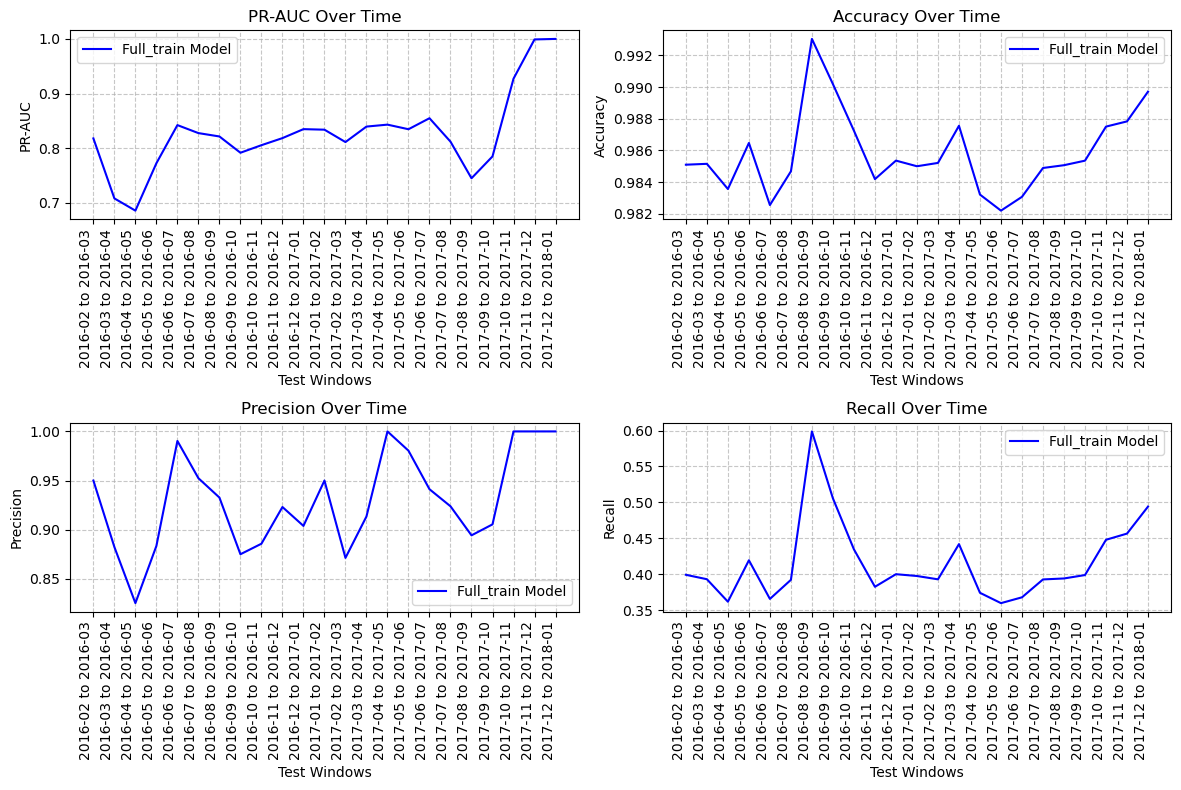

In [7]:
# Load data and setup
df = pd.read_pickle("C:/Users/hridi/Downloads/WF_DCPT project/Jan 17th presentation_ 4 Seperate models/model_ready_data.pkl")

# Define time periods
initial_start = pd.Timestamp('2015-01-01')
initial_end = pd.Timestamp('2015-12-31')
training_end = pd.Timestamp('2017-11-30')
eval_end = pd.Timestamp('2018-01-31')

def create_model(learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Input(shape=(39,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
    )
    return model


# -------------- Model 3: Dynamic Full train Model (Training) --------------
print("\nStarting Model 3 (Dynamic Full_train - Training)...")

# Initialize storage for models, scaler, and results
models = {}
scaler = StandardScaler()
model3_train_results = []
training_histories = []  # For storing training histories

# Set up training loop
current_date = pd.Timestamp('2016-02-01')  # Start from Feb 2016
last_valid_start = pd.Timestamp('2017-12-01')  # End at Dec 2017


# Training Loop
while current_date <= last_valid_start:
    # Define training window (accumulated data up to previous month end)
    train_end = current_date - pd.DateOffset(days=1)
    train_start = pd.Timestamp('2015-01-01')
  
    # Get accumulated training data
    train_mask = (df['order_date'] >= train_start) & (df['order_date'] <= train_end)
    train_data = df[train_mask]
    print(f"\nRetraining Model 3 for data up to {train_end.strftime('%Y-%m-%d')}...")
    print(f"Training data size: {len(train_data)}")

    # Prepare training data
    X_train = train_data.drop(columns=['fraud', 'order_date'])
    y_train = train_data['fraud']


    # Split and scale
    X_train, X_val, y_train, y_val = train_test_split(
      X_train, y_train,
      test_size=0.2,
      random_state=42
    )

    # Use initial scaler to all
    if current_date == pd.Timestamp('2016-02-01'):
        X_train_scaled = scaler.fit_transform(X_train)
    else:
       X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    current_model = create_model()
    history = current_model.fit(
      X_train_scaled, y_train,
      validation_data=(X_val_scaled, y_val),
      epochs=10,
      batch_size=512,
      verbose=1
    )

    models[train_end] = current_model
    training_histories.append({
      'window_end': train_end,
      'history': history
    })

    model3_train_results.append({
      'date': train_end,
      'train_loss': history.history['loss'][-1],
      'val_loss': history.history['val_loss'][-1],
      'train_accuracy': history.history['accuracy'][-1],
      'val_accuracy': history.history['val_accuracy'][-1],
      'train_auc_pr': history.history['auc_pr'][-1],
      'val_auc_pr': history.history['val_auc_pr'][-1]
    })

    current_date += pd.DateOffset(months=1)

# Convert training results to DataFrame
model3_train_results_df = pd.DataFrame(model3_train_results)
print("\nTraining Metrics (Model 3):")
print(model3_train_results_df)



# -------------- Model 3: Testing on Rolling Windows --------------
print("\nStarting Model 3 Testing...")

# Testing Loop
model3_results = []
current_date = pd.Timestamp('2016-02-01')

while current_date <= last_valid_start:
    test_start = current_date
    test_end_month = current_date.month + 1
    test_end_year = current_date.year
    if test_end_month > 12:
        test_end_month -= 12
        test_end_year += 1

    last_day = calendar.monthrange(test_end_year, test_end_month)[1]
    test_end = pd.Timestamp(f"{test_end_year}-{test_end_month:02d}-{last_day:02d}")

    train_end = current_date - pd.DateOffset(days=1)
    current_model = models[train_end]

    test_mask = (df['order_date'] > test_start) & (df['order_date'] <= test_end)
    test_data = df[test_mask]

    if len(test_data) > 0:
      X_test = test_data.drop(columns=['fraud', 'order_date'])
      y_test = test_data['fraud']
      X_test_scaled = scaler.transform(X_test)

      y_pred_proba = current_model.predict(X_test_scaled, verbose=0)
      threshold = np.quantile(y_pred_proba, 0.99)  # Top 1%
      y_pred = (y_pred_proba >= threshold).astype(int)
      print(f"Threshold value for this window: {threshold}")

      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      precisions, recalls, _ = precision_recall_curve(y_test, y_pred_proba)
      pr_auc = auc(recalls, precisions)

      model3_results.append({
          'date': current_date,
          'model': 'Full_train',
          'window': f"{test_start.strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
          'PR-AUC': pr_auc,
          'Accuracy': accuracy_score(y_test, y_pred),
          'Precision': precision,   
          'Recall': recall,
          'threshold': threshold
      })

    current_date += pd.DateOffset(months=1)

# Print results
model3_results_df = pd.DataFrame(model3_results)
print("\nMetrics for each test window (Full_train Model):")
print(model3_results_df[['window', 'PR-AUC', 'Accuracy', 'Precision', 'Recall']])

print("\nAverage metrics (Full_train Model):")
average_metrics = model3_results_df[['PR-AUC', 'Accuracy', 'Precision', 'Recall']].mean()
print(average_metrics)

# Plot test metrics
metrics = ['PR-AUC', 'Accuracy', 'Precision', 'Recall']
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
   plt.subplot(2, 2, i + 1)
   plt.plot(range(len(model3_results_df)), model3_results_df[metric], 
            label='Full_train Model', color='blue')
   plt.title(f'{metric} Over Time')
   plt.xlabel('Test Windows')
   plt.ylabel(metric)
   plt.legend()
   plt.xticks(range(len(model3_results_df)), 
              model3_results_df['window'], 
              rotation=90,
              ha='right')
   plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Save results
model3_train_results_df.to_csv('model3_Full_train Model_training_metrics.csv', index=False)
model3_results_df.to_csv('model3_Full_train Model_test_metrics.csv', index=False)

# Store final results for comparison
model3_final_results = {
    'model_name': 'Full_train Model',
    'train_metrics': model3_train_results_df,
    'test_metrics': model3_results_df
}

# Save results for later comparison
np.save('model3_results.npy', model3_final_results, allow_pickle=True)

# Model -2 Incremental

Loading and preparing initial data...

Starting Model 2: Initial Training on 2015 data...
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8391 - auc_pr: 0.0238 - loss: 0.3655 - precision: 0.0224 - recall: 0.1545 - val_accuracy: 0.9784 - val_auc_pr: 0.4443 - val_loss: 0.0650 - val_precision: 1.0000 - val_recall: 0.0037
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9781 - auc_pr: 0.2850 - loss: 0.0769 - precision: 0.6005 - recall: 0.0401 - val_accuracy: 0.9815 - val_auc_pr: 0.6212 - val_loss: 0.0463 - val_precision: 0.9000 - val_recall: 0.1661
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9804 - auc_pr: 0.4762 - loss: 0.0589 - precision: 0.7245 - recall: 0.1674 - val_accuracy: 0.9852 - val_auc_pr: 0.6802 - val_loss: 0.0416 - val_precision: 0.8525 - val_recall: 0.3838
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9825 - auc_pr: 0.5770 - loss: 0.0504 - precision: 0.7134 - recall: 0.3406 - val_accuracy: 0.9862 - val_auc_p

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9815 - auc_pr: 0.6195 - loss: 0.0536 - precision: 0.6534 - recall: 0.4808 - val_accuracy: 0.9912 - val_auc_pr: 0.7755 - val_loss: 0.0364 - val_precision: 0.9333 - val_recall: 0.6364
Storing weights from 2016-05 model for next month's training
Testing period: 2016-05-30 to 2016-07-29
Test data size: 10243
Threshold value for this window: 0.7700523698329923

Processing month ending 2016-06-29...
Training data period: 2016-06-01 to 2016-06-30
Training data size: 4900
Epoch 1/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9798 - auc_pr: 0.6728 - loss: 0.0502 - precision: 0.6607 - recall: 0.5277 - val_accuracy: 0.9898 - val_auc_pr: 0.5452 - val_loss: 0.0342 - val_precision: 0.7000 - val_recall: 0.5000
Epoch 2/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9845 - auc_pr: 0.6196 - loss: 0.0415 - precision: 0.6797 - recall: 0.4662 - val_accuracy: 0.9898 - val_auc_pr: 0.5494 - val_loss: 0.0336 - val_precision: 0.7000 - val_re

Threshold value for this window: 0.7559121465682986

Processing month ending 2017-01-29...
Training data period: 2017-01-01 to 2017-01-31
Training data size: 5046
Epoch 1/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9812 - auc_pr: 0.6257 - loss: 0.0536 - precision: 0.7069 - recall: 0.4503 - val_accuracy: 0.9941 - val_auc_pr: 0.7688 - val_loss: 0.0174 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 2/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9851 - auc_pr: 0.7268 - loss: 0.0422 - precision: 0.7516 - recall: 0.5927 - val_accuracy: 0.9941 - val_auc_pr: 0.7990 - val_loss: 0.0175 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 3/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9864 - auc_pr: 0.7533 - loss: 0.0344 - precision: 0.8032 - recall: 0.5341 - val_accuracy: 0.9941 - val_auc_pr: 0.8001 - val_loss: 0.0174 - val_precision: 0.8571 - val_recall: 0.7500
Storing weights from 2017-01 model for next month's training
Testing period: 2017-01-30 to 2017-03-29

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9826 - auc_pr: 0.5287 - loss: 0.0577 - precision: 0.6489 - recall: 0.4305 - val_accuracy: 0.9883 - val_auc_pr: 0.7363 - val_loss: 0.0403 - val_precision: 0.9167 - val_recall: 0.5000
Epoch 2/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9837 - auc_pr: 0.6038 - loss: 0.0548 - precision: 0.7580 - recall: 0.4624 - val_accuracy: 0.9893 - val_auc_pr: 0.7370 - val_loss: 0.0393 - val_precision: 0.9231 - val_recall: 0.5455
Epoch 3/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9839 - auc_pr: 0.6676 - loss: 0.0517 - precision: 0.7097 - recall: 0.5177 - val_accuracy: 0.9883 - val_auc_pr: 0.7443 - val_loss: 0.0384 - val_precision: 0.8571 - val_recall: 0.5455
Storing weights from 2017-08 model for next month's training
Testing period: 2017-08-29 to 2017-10-28
Test data size: 7670
Threshold value for this window: 0.7875660735368727

Processing month ending 2017-09-28...
Training data period: 2017-09-01 to 2017-09-30
Training dat

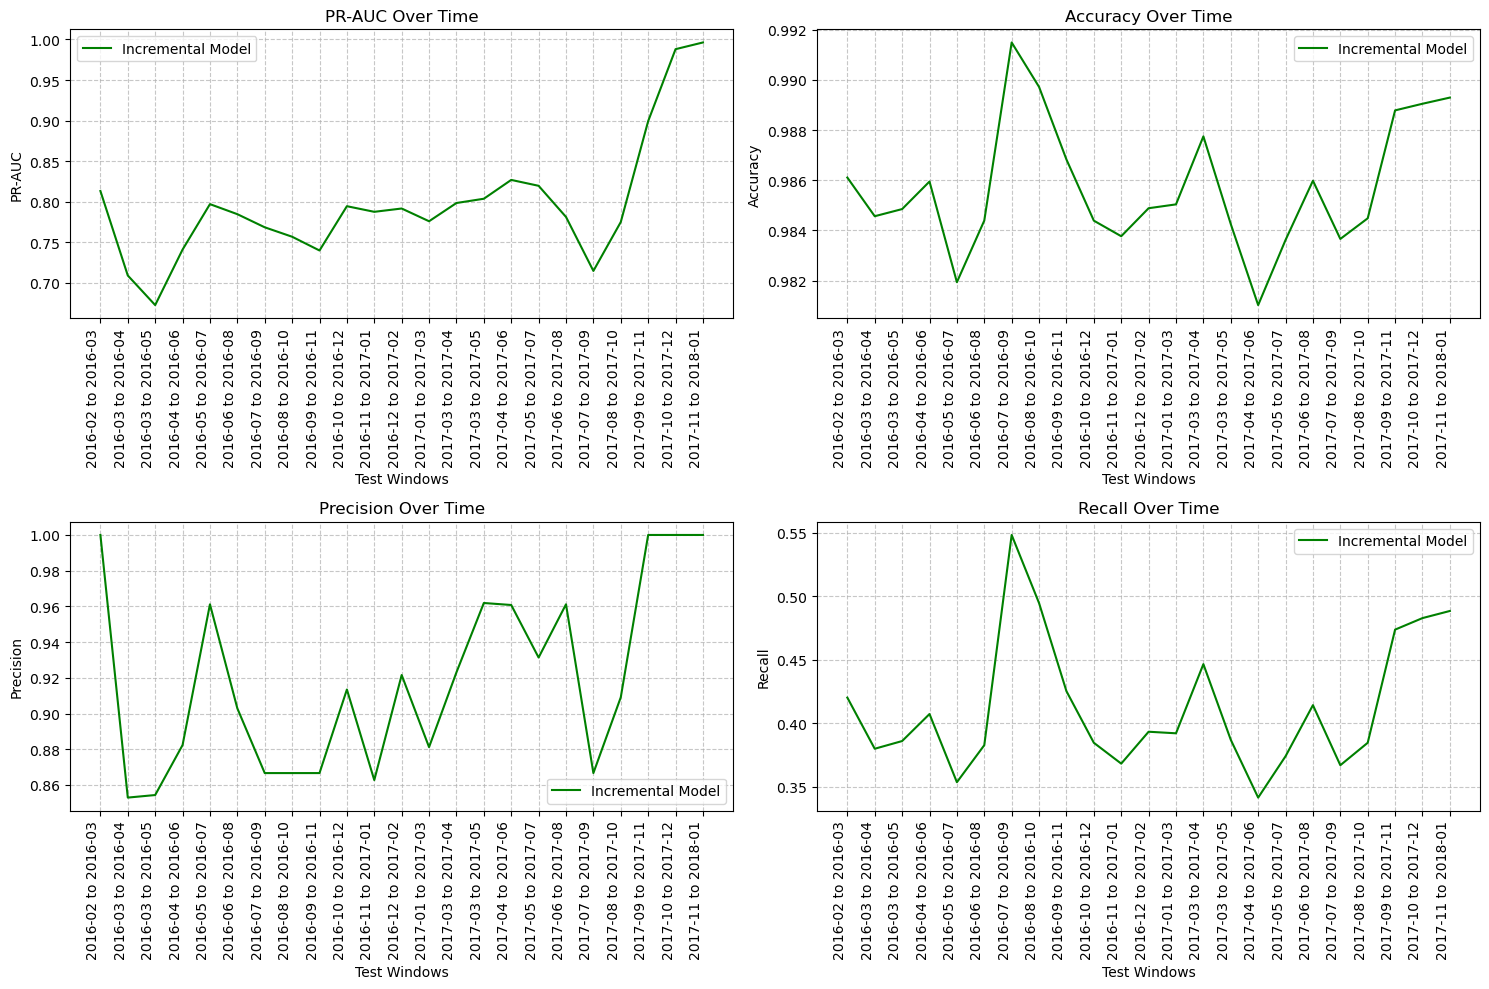

In [8]:
# Load data
print("Loading and preparing initial data...")
df = pd.read_pickle("C:/Users/hridi/Downloads/WF_DCPT project/Jan 17th presentation_ 4 Seperate models/model_ready_data.pkl")

# Define time periods
initial_start = pd.Timestamp('2015-01-01')
initial_end = pd.Timestamp('2015-12-31')
training_end = pd.Timestamp('2017-11-30')
eval_end = pd.Timestamp('2018-01-31')

def create_model(learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Input(shape=(39,)),
        keras.layers.Dense(64, activation='relu', name='dense_1'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu', name='dense_2'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='relu', name='dense_3'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid', name='output')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
    )
    return model

# -------------- Model 2: Initial Training (2015) --------------
print("\nStarting Model 2: Initial Training on 2015 data...")

# Initialize storage
models = {}
#scalers = {}
model2_train_results = []
model2_results = []

# Get 2015 data
initial_mask = (df['order_date'] >= initial_start) & (df['order_date'] <= initial_end)
initial_data = df[initial_mask]

# Prepare 2015 data
X_initial = initial_data.drop(columns=['fraud', 'order_date'])
y_initial = initial_data['fraud']

# Split 2015 data
X_train, X_val, y_train, y_val = train_test_split(
    X_initial, y_initial,
    test_size=0.2,
    random_state=42
)

# Scale 2015 data
initial_scaler = StandardScaler()
X_train_scaled = initial_scaler.fit_transform(X_train)
X_val_scaled = initial_scaler.transform(X_val)

# Train 2015 model
initial_model = create_model(learning_rate=0.001)
initial_history = initial_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=512,
    verbose=1
)

# Store 2015 model and scaler
models[initial_end] = initial_model
#scalers[initial_end] = initial_scaler
previous_weights = initial_model.get_weights()

# Store 2015 training metrics
model2_train_results.append({
    'date': initial_end,
    'train_loss': initial_history.history['loss'][-1],
    'val_loss': initial_history.history['val_loss'][-1],
    'train_accuracy': initial_history.history['accuracy'][-1],
    'val_accuracy': initial_history.history['val_accuracy'][-1],
    'train_auc_pr': initial_history.history['auc_pr'][-1],
    'val_auc_pr': initial_history.history['val_auc_pr'][-1]
})

# -------------- Model 2: Monthly Updates (2016-2017) --------------
print("\nStarting Model 2: Monthly Updates...")

current_date = pd.Timestamp('2016-01-31')  # First update month
last_train_date = pd.Timestamp('2017-11-30')  # Last update month

while current_date <= last_train_date:
    print(f"\nProcessing month ending {current_date.strftime('%Y-%m-%d')}...")
    
    # Get current month's training data
    month_start = current_date.replace(day=1)  # First day of current month
    month_end = (month_start + pd.DateOffset(months=1) - pd.DateOffset(days=1))  # Last day of current month
    
    train_mask = (df['order_date'] > month_start) & (df['order_date'] <= month_end)
    train_data = df[train_mask]
    print(f"Training data period: {month_start.strftime('%Y-%m-%d')} to {month_end.strftime('%Y-%m-%d')}")
    print(f"Training data size: {len(train_data)}")
    
    # Prepare current month's training data
    X_train = train_data.drop(columns=['fraud', 'order_date'])
    y_train = train_data['fraud']
    
    # Split current month's data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        random_state=42
    )
    
    # Scale current month's data
    X_train_scaled = initial_scaler.transform(X_train)
    X_val_scaled = initial_scaler.transform(X_val)
    
    # Create new model with previous weights
    current_model = create_model(learning_rate=0.0001)
    current_model.set_weights(previous_weights)
    
    # Train on current month
    history = current_model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=3,
        batch_size=256,
        verbose=1
    )
    
    # Store model, scaler, and weights
    models[current_date] = current_model
    #scalers[current_date] = current_scaler
    previous_weights = current_model.get_weights()
    print(f"Storing weights from {current_date.strftime('%Y-%m')} model for next month's training")
    
    # Store training metrics
    model2_train_results.append({
        'date': current_date,
        'train_loss': history.history['loss'][-1],
        'val_loss': history.history['val_loss'][-1],
        'train_accuracy': history.history['accuracy'][-1],
        'val_accuracy': history.history['val_accuracy'][-1],
        'train_auc_pr': history.history['auc_pr'][-1],
        'val_auc_pr': history.history['val_auc_pr'][-1]
    })
    
    # -------------- Testing on Next Two Months --------------
    # Define test window
    test_start = current_date + pd.DateOffset(days=1)
    test_end = test_start + pd.DateOffset(months=2) - pd.DateOffset(days=1)
    
    test_mask = (df['order_date'] >= test_start) & (df['order_date'] <= test_end)
    test_data = df[test_mask]
    
    print(f"Testing period: {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}")
    print(f"Test data size: {len(test_data)}")
    
    if len(test_data) > 0:
        # Prepare and scale test data using current month's scaler
        X_test = test_data.drop(columns=['fraud', 'order_date'])
        y_test = test_data['fraud']
        X_test_scaled = initial_scaler.transform(X_test)
        
        # Get predictions
        y_pred_proba = current_model.predict(X_test_scaled, verbose=0)
        # With:
        threshold = np.quantile(y_pred_proba, 0.99)  # Top 1%
        y_pred = (y_pred_proba >= threshold).astype(int)
        print(f"Threshold value for this window: {threshold}")
        
        # Calculate metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precisions, recalls, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recalls, precisions)
        
        # Store results
        model2_results.append({
            'date': current_date,
            'model': 'Incremental',
            'window': f"{test_start.strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            'PR-AUC': pr_auc,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision,
            'Recall': recall,
            'threshold': threshold
        })
    
    # Move to next month
    current_date = (current_date + pd.DateOffset(months=1))

# -------------- Results Analysis --------------
# Convert results to DataFrames
model2_train_results_df = pd.DataFrame(model2_train_results)
model2_results_df = pd.DataFrame(model2_results)

print("\nTraining Metrics:")
print(model2_train_results_df)

print("\nTest Metrics for each window:")
print(model2_results_df[['window', 'PR-AUC', 'Accuracy', 'Precision', 'Recall']])

print("\nAverage Test Metrics:")
print(model2_results_df[['PR-AUC', 'Accuracy', 'Precision', 'Recall']].mean())

# Plot metrics over time
plt.figure(figsize=(15, 10))
metrics = ['PR-AUC', 'Accuracy', 'Precision', 'Recall']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.plot(range(len(model2_results_df)), model2_results_df[metric], 
             label='Incremental Model', color='green')
    plt.title(f'{metric} Over Time')
    plt.xlabel('Test Windows')
    plt.ylabel(metric)
    plt.legend()
    
    plt.xticks(range(len(model2_results_df)), 
               model2_results_df['window'], 
               rotation=90,
               ha='right')
    
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save results
model2_train_results_df.to_csv('model2_training_metrics.csv', index=False)
model2_results_df.to_csv('model2_test_metrics.csv', index=False)

# Store final results for comparison
model2_final_results = {
    'model_name': 'Incremental',
    'train_metrics': model2_train_results_df,
    'test_metrics': model2_results_df
}

# Save results for later comparison
np.save('model2_results.npy', model2_final_results, allow_pickle=True)

# Model -2 Transfer

Loading and preparing initial data...

Step 1: Training initial model on 2015 data...
Training 2015 base model (all layers trainable)...
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9665 - auc_pr: 0.0214 - loss: 0.2255 - precision: 0.0127 - recall: 0.0050 - val_accuracy: 0.9783 - val_auc_pr: 0.4397 - val_loss: 0.0640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9784 - auc_pr: 0.3014 - loss: 0.0751 - precision: 0.6201 - recall: 0.0253 - val_accuracy: 0.9821 - val_auc_pr: 0.5907 - val_loss: 0.0477 - val_precision: 0.8615 - val_recall: 0.2066
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9798 - auc_pr: 0.4601 - loss: 0.0567 - precision: 0.6817 - recall: 0.1546 - val_accuracy: 0.9843 - val_auc_pr: 0.6655 - val_loss: 0.0408 - val_precision: 0.7586 - val_recall: 0.4059
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9815 - auc_pr: 0.5671 - loss: 0.0506 - precision: 0.7

Threshold value for this window: 0.6222924280166634

Processing month ending 2016-04-29...
Training data period: 2016-04-01 to 2016-04-30
Training data size: 4964
Creating new model for 2016-04
Loading weights from previous model
Freezing layers except last two...
Layer dense_1 frozen: trainable = False
Layer dropout_369 frozen: trainable = False
Layer dense_2 frozen: trainable = False
Layer dropout_370 frozen: trainable = False
Layer dense_3 frozen: trainable = False

Trainable status after freezing:
Layer dense_1: trainable = False
Layer dropout_369: trainable = False
Layer dense_2: trainable = False
Layer dropout_370: trainable = False
Layer dense_3: trainable = False
Layer dropout_371: trainable = True
Layer output: trainable = True
Training model for 2016-04...
Epoch 1/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9764 - auc_pr: 0.5522 - loss: 0.0842 - precision: 0.6748 - recall: 0.3186 - val_accuracy: 0.9849 - val_auc_pr: 0.6659 - val_loss: 0.0528 - val_precision: 0.733

Epoch 3/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9916 - auc_pr: 0.6788 - loss: 0.0431 - precision: 0.9578 - recall: 0.4414 - val_accuracy: 0.9864 - val_auc_pr: 0.6882 - val_loss: 0.0401 - val_precision: 0.8000 - val_recall: 0.2353
Saved weights from 2016-08 model for next month's training
Testing period: 2016-08-30 to 2016-10-29
Test data size: 10411
Threshold value for this window: 0.563459265232085

Processing month ending 2016-09-29...
Training data period: 2016-09-01 to 2016-09-30
Training data size: 5004
Creating new model for 2016-09
Loading weights from previous model
Freezing layers except last two...
Layer dense_1 frozen: trainable = False
Layer dropout_384 frozen: trainable = False
Layer dense_2 frozen: trainable = False
Layer dropout_385 frozen: trainable = False
Layer dense_3 frozen: trainable = False

Trainable status after freezing:
Layer dense_1: trainable = False
Layer dropout_384: trainable = False
Layer dense_2: trainable = False
Layer dropout_385: train

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9791 - auc_pr: 0.5546 - loss: 0.0742 - precision: 0.7463 - recall: 0.1954 - val_accuracy: 0.9881 - val_auc_pr: 0.7673 - val_loss: 0.0303 - val_precision: 0.8333 - val_recall: 0.3125
Epoch 2/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9816 - auc_pr: 0.5764 - loss: 0.0697 - precision: 0.8010 - recall: 0.2807 - val_accuracy: 0.9881 - val_auc_pr: 0.7661 - val_loss: 0.0301 - val_precision: 0.8333 - val_recall: 0.3125
Epoch 3/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9819 - auc_pr: 0.5783 - loss: 0.0574 - precision: 0.6550 - recall: 0.1874 - val_accuracy: 0.9881 - val_auc_pr: 0.7661 - val_loss: 0.0300 - val_precision: 0.8333 - val_recall: 0.3125
Saved weights from 2017-01 model for next month's training
Testing period: 2017-01-30 to 2017-03-29
Test data size: 10027
Threshold value for this window: 0.43637578964233326

Processing month ending 2017-02-28...
Training data period: 2017-02-01 to 2017-02-28
Training data

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9815 - auc_pr: 0.6829 - loss: 0.0687 - precision: 0.8673 - recall: 0.2508 - val_accuracy: 0.9885 - val_auc_pr: 0.9008 - val_loss: 0.0311 - val_precision: 0.9231 - val_recall: 0.5455
Epoch 2/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9820 - auc_pr: 0.6698 - loss: 0.0951 - precision: 0.9276 - recall: 0.3751 - val_accuracy: 0.9885 - val_auc_pr: 0.9008 - val_loss: 0.0309 - val_precision: 0.9231 - val_recall: 0.5455
Epoch 3/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9795 - auc_pr: 0.5827 - loss: 0.0823 - precision: 0.7392 - recall: 0.2250 - val_accuracy: 0.9885 - val_auc_pr: 0.9008 - val_loss: 0.0308 - val_precision: 0.9231 - val_recall: 0.5455
Saved weights from 2017-06 model for next month's training
Testing period: 2017-06-29 to 2017-08-28
Test data size: 10273
Threshold value for this window: 0.16207745432853743

Processing month ending 2017-07-28...
Training data period: 2017-07-01 to 2017-07-31
Training data

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9869 - auc_pr: 0.8729 - loss: 0.0596 - precision: 1.0000 - recall: 0.4256 - val_accuracy: 0.9849 - val_auc_pr: 1.0000 - val_loss: 0.0357 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9875 - auc_pr: 0.7492 - loss: 0.0754 - precision: 1.0000 - recall: 0.3966 - val_accuracy: 0.9849 - val_auc_pr: 1.0000 - val_loss: 0.0355 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9864 - auc_pr: 0.6960 - loss: 0.0910 - precision: 1.0000 - recall: 0.4375 - val_accuracy: 0.9849 - val_auc_pr: 1.0000 - val_loss: 0.0353 - val_precision: 1.0000 - val_recall: 0.5000
Saved weights from 2017-11 model for next month's training
Testing period: 2017-11-29 to 2018-01-28
Test data size: 4111
Threshold value for this window: 0.8375962615013132

Training Metrics:
         date  train_loss  val_loss  train_accuracy  val_accuracy  \
0  2015-12-31    

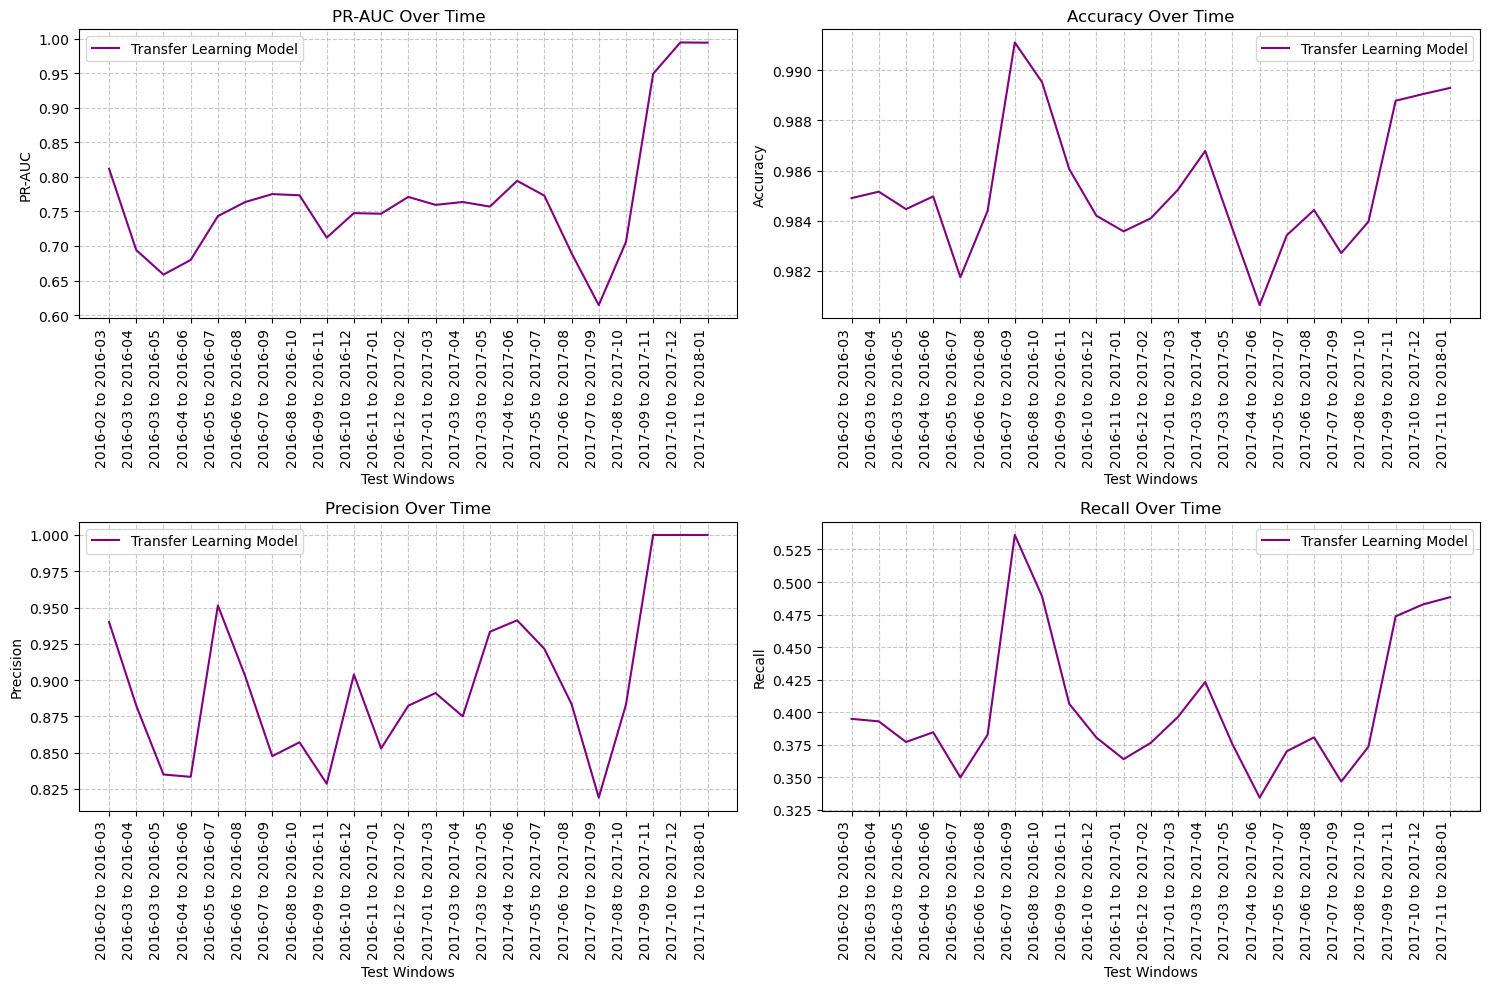

In [9]:
# Load data
print("Loading and preparing initial data...")
df = pd.read_pickle("C:/Users/hridi/Downloads/WF_DCPT project/Jan 17th presentation_ 4 Seperate models/model_ready_data.pkl")

# Define time periods
initial_start = pd.Timestamp('2015-01-01')
initial_end = pd.Timestamp('2015-12-31')
training_end = pd.Timestamp('2017-11-30')
eval_end = pd.Timestamp('2018-01-31')

def create_model(learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Input(shape=(39,)),
        keras.layers.Dense(64, activation='relu', name='dense_1'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu', name='dense_2'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='relu', name='dense_3'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid', name='output')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
    )
    return model

# -------------- Step 1: Initial Training (2015) --------------
print("\nStep 1: Training initial model on 2015 data...")

# Initialize storage
models = {}
#scalers = {}
model2_transfer_train_results = []
model2_transfer_results = []

# Get 2015 data
initial_mask = (df['order_date'] >= initial_start) & (df['order_date'] <= initial_end)
initial_data = df[initial_mask]

# Prepare 2015 data
X_initial = initial_data.drop(columns=['fraud', 'order_date'])
y_initial = initial_data['fraud']

# Split 2015 data
X_train, X_val, y_train, y_val = train_test_split(
    X_initial, y_initial,
    test_size=0.2,
    random_state=42
)

# Scale 2015 data
initial_scaler = StandardScaler()
X_train_scaled = initial_scaler.fit_transform(X_train)
X_val_scaled = initial_scaler.transform(X_val)

# Train initial 2015 model (no frozen layers for initial training)
print("Training 2015 base model (all layers trainable)...")
initial_model = create_model(learning_rate=0.001)
initial_history = initial_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=512,
    verbose=1
)

# Save initial model's weights
initial_weights = initial_model.get_weights()
print("Saved 2015 model weights for transfer learning")

# Store 2015 training metrics
model2_transfer_train_results.append({
    'date': initial_end,
    'train_loss': initial_history.history['loss'][-1],
    'val_loss': initial_history.history['val_loss'][-1],
    'train_accuracy': initial_history.history['accuracy'][-1],
    'val_accuracy': initial_history.history['val_accuracy'][-1],
    'train_auc_pr': initial_history.history['auc_pr'][-1],
    'val_auc_pr': initial_history.history['val_auc_pr'][-1]
})

# -------------- Step 2: Monthly Transfer Learning (2016-2017) --------------
print("\nStep 2: Starting monthly transfer learning updates...")

current_date = pd.Timestamp('2016-01-31')  # First update month
last_train_date = pd.Timestamp('2017-11-30')  # Last update month
previous_weights = initial_weights  # Start with 2015 model weights

while current_date <= last_train_date:
    print(f"\nProcessing month ending {current_date.strftime('%Y-%m-%d')}...")
    
    # Get current month's training data
    month_start = current_date.replace(day=1)  # First day of current month
    month_end = (month_start + pd.DateOffset(months=1) - pd.DateOffset(days=1))  # Last day of current month
    
    train_mask = (df['order_date'] > month_start) & (df['order_date'] <= month_end)
    train_data = df[train_mask]
    print(f"Training data period: {month_start.strftime('%Y-%m-%d')} to {month_end.strftime('%Y-%m-%d')}")
    print(f"Training data size: {len(train_data)}")
    
    # Prepare current month's training data
    X_train = train_data.drop(columns=['fraud', 'order_date'])
    y_train = train_data['fraud']
    
    # Split current month's data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        random_state=42
    )
    
    # Scale current month's data
    X_train_scaled = initial_scaler.transform(X_train)
    X_val_scaled = initial_scaler.transform(X_val)
    
    print(f"Creating new model for {current_date.strftime('%Y-%m')}")
    # Create new model
    current_model = create_model(learning_rate=0.0001)
    
    # Load weights from previous training
    print(f"Loading weights from previous model")
    current_model.set_weights(previous_weights)
    
    # Freeze all layers except last two
    print("Freezing layers except last two...")
    for layer in current_model.layers[:-2]:
        layer.trainable = False
        print(f"Layer {layer.name} frozen: trainable = {layer.trainable}")
    
    # Verify trainable status
    print("\nTrainable status after freezing:")
    for layer in current_model.layers:
        print(f"Layer {layer.name}: trainable = {layer.trainable}")
    
    # Recompile model after freezing layers
    current_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
    )
    
    # Train on current month
    print(f"Training model for {current_date.strftime('%Y-%m')}...")
    history = current_model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=3,
        batch_size=256,
        verbose=1
    )
    
    # Save weights for next month's training
    previous_weights = current_model.get_weights()
    print(f"Saved weights from {current_date.strftime('%Y-%m')} model for next month's training")
    
    # Store current model and scaler
    models[current_date] = current_model
    #scalers[current_date] = current_scaler
    
    # Store training metrics
    model2_transfer_train_results.append({
        'date': current_date,
        'train_loss': history.history['loss'][-1],
        'val_loss': history.history['val_loss'][-1],
        'train_accuracy': history.history['accuracy'][-1],
        'val_accuracy': history.history['val_accuracy'][-1],
        'train_auc_pr': history.history['auc_pr'][-1],
        'val_auc_pr': history.history['val_auc_pr'][-1]
    })
    
    # -------------- Testing on Next Two Months --------------
    test_start = current_date + pd.DateOffset(days=1)
    test_end = test_start + pd.DateOffset(months=2) - pd.DateOffset(days=1)
    
    test_mask = (df['order_date'] >= test_start) & (df['order_date'] <= test_end)
    test_data = df[test_mask]
    
    print(f"Testing period: {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}")
    print(f"Test data size: {len(test_data)}")
    
    if len(test_data) > 0:
        # Prepare and scale test data
        X_test = test_data.drop(columns=['fraud', 'order_date'])
        y_test = test_data['fraud']
        X_test_scaled = initial_scaler.transform(X_test)
        
        # Get predictions
        y_pred_proba = current_model.predict(X_test_scaled, verbose=0)
        # With:
        threshold = np.quantile(y_pred_proba, 0.99)  # Top 1%
        y_pred = (y_pred_proba >= threshold).astype(int)
        print(f"Threshold value for this window: {threshold}")
        
        # Calculate metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precisions, recalls, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recalls, precisions)
        
        # Store results
        model2_transfer_results.append({
            'date': current_date,
            'model': 'Transfer Learning',
            'window': f"{test_start.strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            'PR-AUC': pr_auc,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision,
            'Recall': recall,
            'threshold': threshold
        })
    
    # Move to next month
    current_date = (current_date + pd.DateOffset(months=1))

# -------------- Results Analysis --------------
model2_transfer_train_results_df = pd.DataFrame(model2_transfer_train_results)
model2_transfer_results_df = pd.DataFrame(model2_transfer_results)

print("\nTraining Metrics:")
print(model2_transfer_train_results_df)

print("\nTest Metrics for each window:")
print(model2_transfer_results_df[['window', 'PR-AUC', 'Accuracy', 'Precision', 'Recall']])

print("\nAverage Test Metrics:")
print(model2_transfer_results_df[['PR-AUC', 'Accuracy', 'Precision', 'Recall']].mean())

# Plot metrics over time
plt.figure(figsize=(15, 10))
metrics = ['PR-AUC', 'Accuracy', 'Precision', 'Recall']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.plot(range(len(model2_transfer_results_df)), model2_transfer_results_df[metric], 
             label='Transfer Learning Model', color='purple')
    plt.title(f'{metric} Over Time')
    plt.xlabel('Test Windows')
    plt.ylabel(metric)
    plt.legend()
    
    plt.xticks(range(len(model2_transfer_results_df)), 
               model2_transfer_results_df['window'], 
               rotation=90,
               ha='right')
    
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save results
model2_train_results_df.to_csv('model2_transfer_learning_training_metrics.csv', index=False)
model2_results_df.to_csv('model2_transfer_learning_test_metrics.csv', index=False)

# Store final results for comparison
model2_transfer_final_results = {
    'model_name': 'Transfer_Learning',
    'train_metrics': model2_transfer_train_results_df,
    'test_metrics': model2_transfer_results_df
}

# Save results for later comparison
np.save('model2_transfer_results.npy', model2_transfer_final_results, allow_pickle=True)

# Comparison

In [10]:
# Load results
model1_results = np.load('model1_results.npy', allow_pickle=True).item()
model2_results = np.load('model2_results.npy', allow_pickle=True).item()
model2_transfer_results = np.load('model2_transfer_results.npy', allow_pickle=True).item()
model3_results = np.load('model3_results.npy', allow_pickle=True).item()

# Create a dictionary of test metrics for each model
test_metrics = {
    'Static': model1_results['test_metrics'],
    'Incremental': model2_results['test_metrics'],
    'Transfer Learning': model2_transfer_results['test_metrics'],
    'Full Training': model3_results['test_metrics']
}

# Calculate average metrics for each model
avg_metrics = {}
for model_name, metrics in test_metrics.items():
    avg_metrics[model_name] = {
        'PR-AUC': metrics['PR-AUC'].mean(),
        'Accuracy': metrics['Accuracy'].mean(),
        'Precision': metrics['Precision'].mean(),
        'Recall': metrics['Recall'].mean()
    }

# Convert to DataFrame for easy viewing
avg_metrics_df = pd.DataFrame(avg_metrics).round(4)
print("\nAverage Metrics Across All Test Windows:")
print(avg_metrics_df)

# Print detailed metrics for each window
print("\nDetailed Metrics for Each Test Window:")
metrics = ['PR-AUC', 'Accuracy', 'Precision', 'Recall']

for window_idx in range(len(test_metrics['Static'])):
    print(f"\nWindow {window_idx + 1}: {test_metrics['Static'].iloc[window_idx]['window']}")
    window_metrics = {}
    for model_name, results in test_metrics.items():
        window_metrics[model_name] = {
            'PR-AUC': results.iloc[window_idx]['PR-AUC'],
            'Accuracy': results.iloc[window_idx]['Accuracy'],
            'Precision': results.iloc[window_idx]['Precision'],
            'Recall': results.iloc[window_idx]['Recall']
        }
    window_df = pd.DataFrame(window_metrics).round(4)
    print(window_df)

# Find best performing model for each metric
best_models = {}
for metric in metrics:
    best_model = max(avg_metrics.items(), key=lambda x: x[1][metric])[0]
    best_models[metric] = best_model

print("\nBest Performing Models:")
for metric, model in best_models.items():
    print(f"{metric}: {model} ({avg_metrics[model][metric]:.4f})")


Average Metrics Across All Test Windows:
           Static  Incremental  Transfer Learning  Full Training
PR-AUC     0.7793       0.7972             0.7684         0.8266
Accuracy   0.9852       0.9857             0.9853         0.9858
Precision  0.8969       0.9194             0.8985         0.9297
Recall     0.4015       0.4128             0.4035         0.4161

Detailed Metrics for Each Test Window:

Window 1: 2016-02 to 2016-03
           Static  Incremental  Transfer Learning  Full Training
PR-AUC     0.8004       0.8132             0.8118         0.8180
Accuracy   0.9847       0.9861             0.9849         0.9851
Precision  0.9300       1.0000             0.9400         0.9500
Recall     0.3908       0.4202             0.3950         0.3992

Window 2: 2016-03 to 2016-04
           Static  Incremental  Transfer Learning  Full Training
PR-AUC     0.7173       0.7090             0.6941         0.7081
Accuracy   0.9850       0.9846             0.9852         0.9852
Precision  0.

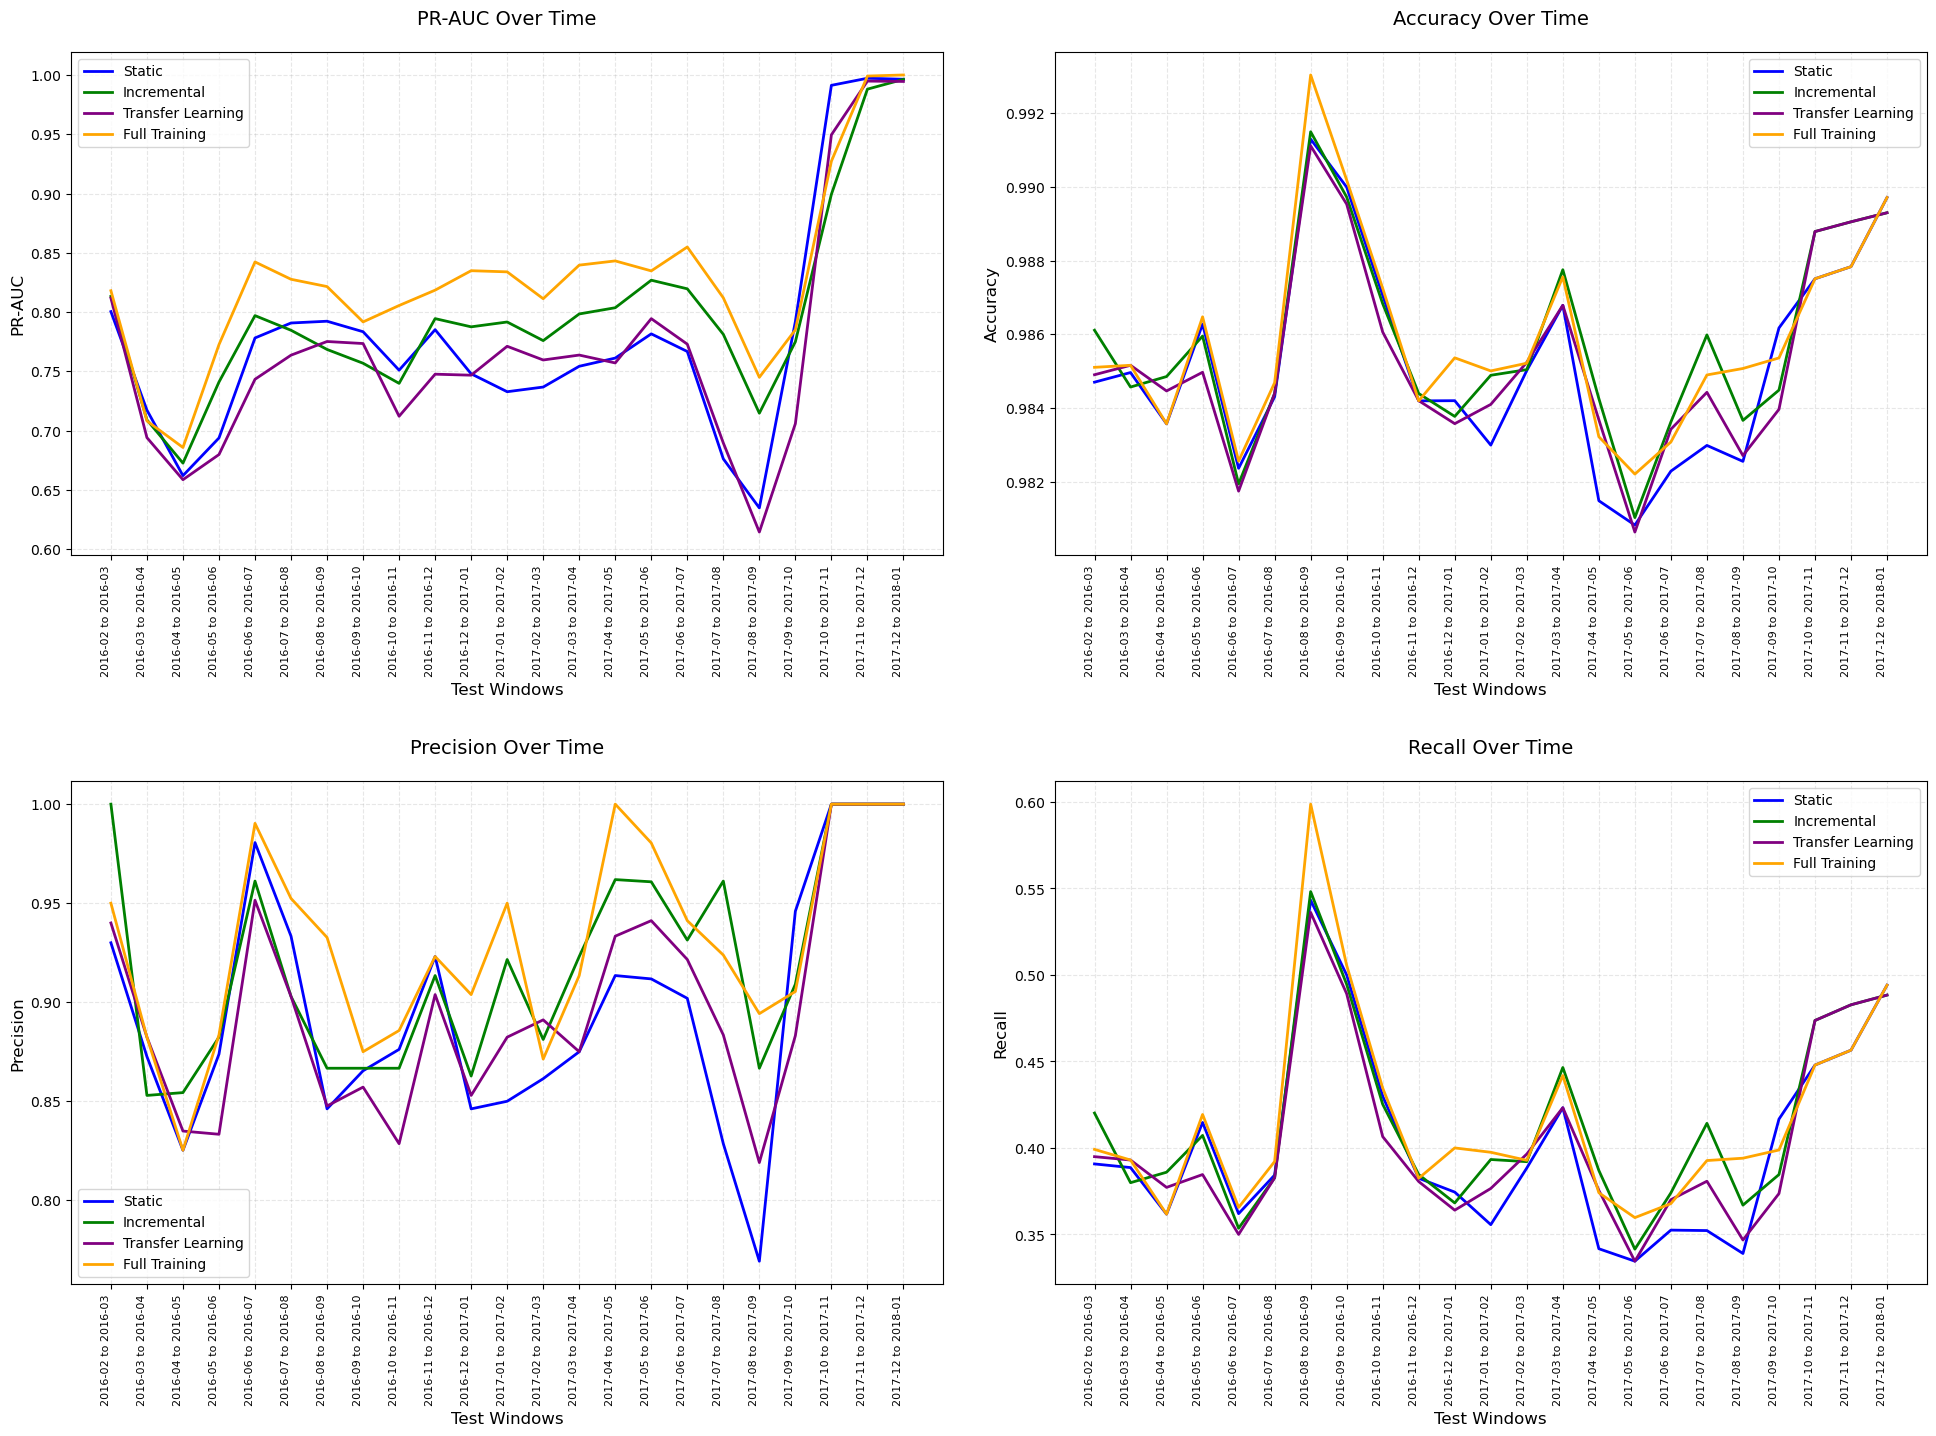

<Figure size 640x480 with 0 Axes>

In [11]:
# Load results
model1_results = np.load('model1_results.npy', allow_pickle=True).item()
model2_results = np.load('model2_results.npy', allow_pickle=True).item()
model2_transfer_results = np.load('model2_transfer_results.npy', allow_pickle=True).item()
model3_results = np.load('model3_results.npy', allow_pickle=True).item()

# Create dictionary of test metrics
test_metrics = {
    'Static': model1_results['test_metrics'],
    'Incremental': model2_results['test_metrics'],
    'Transfer Learning': model2_transfer_results['test_metrics'],
    'Full Training': model3_results['test_metrics']
}

# Plot metrics over time
plt.figure(figsize=(20, 15))
metrics = ['PR-AUC', 'Accuracy', 'Precision', 'Recall']
colors = ['blue', 'green', 'purple', 'orange']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    
    for j, (model_name, results) in enumerate(test_metrics.items()):
        plt.plot(range(len(results)), results[metric], 
                label=model_name, color=colors[j], linewidth=2)
    
    plt.title(f'{metric} Over Time', fontsize=14, pad=20)
    plt.xlabel('Test Windows', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis labels
    window_labels = results['window'].tolist()
    plt.xticks(range(len(window_labels)), window_labels, 
              rotation=90, ha='right', fontsize=8)
    
    # Adjust layout
    plt.gca().set_xticklabels(window_labels)
    plt.grid(True, linestyle='--', alpha=0.3)

# Adjust spacing
plt.tight_layout(pad=3.0)
plt.show()

# Optionally save the plot
plt.savefig('model_comparison_plots.png', dpi=300, bbox_inches='tight')